# Results - Regression Analysis

Evolution of Skills and Wages (relationship)

How does skill diversity to wages?

In [1]:
import numpy as np
import ast
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
import plotly.graph_objects as go
%matplotlib inline

In [74]:
pd.set_option('display.max_columns', None)

## Load data

In [2]:
df = pd.read_json("final_data.json")

# Ideas

correlate skill diversity with specialization, to see if more specialized projects have less diversity

## 1. Descriptive Statistics on correlation

### 1.1 Wage and skill count

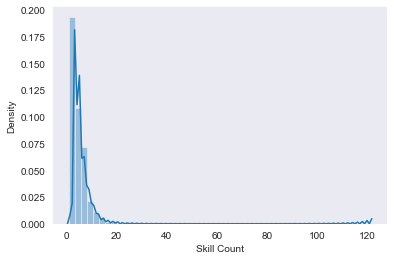

In [130]:
sns.distplot(df.skill_count)
plt.xlabel("Skill Count")
plt.ylabel("Density")
#plt.savefig("distplot_skill_count", dpi=300)

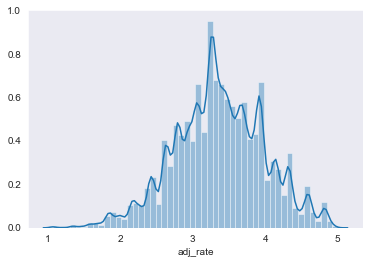

In [14]:
sns.distplot(np.log(df.adj_rate))

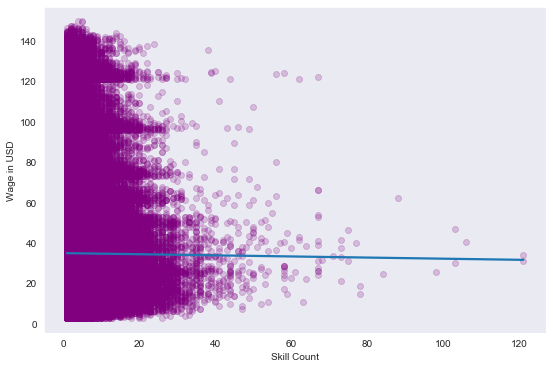

In [65]:
sns.set_style("dark")

fig_dims = (9, 6)

fig, ax = plt.subplots(figsize=fig_dims)

sns.regplot(x="skill_count", y="adj_rate", data = df, scatter_kws = {"color": "purple", "alpha": 0.2}, ci = None, truncate = True, ax=ax)
#ax = sns.regplot(x=df.skill_count, y=np.log(df.adj_rate), scatter_kws = {"color": "purple", "alpha": 0.1},ci = None, truncate = True)
plt.xlabel("Skill Count")
plt.ylabel("Wage in USD")
#plt.savefig("regplot_skill_count", dpi=300)

### 1.2 Wage and network skill diversity

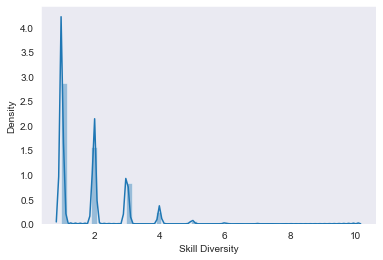

In [131]:
sns.distplot(df.skill_diversity)
plt.xlabel("Skill Diversity")
plt.ylabel("Density")
#plt.savefig("distplot_skill_diversity", dpi=300)

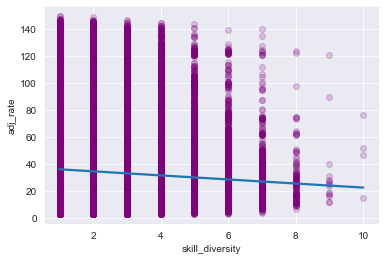

In [61]:
sns.regplot(x="skill_diversity", y="adj_rate", data = df, scatter_kws = {"color": "purple", "alpha": 0.2}, ci = None, truncate = True)

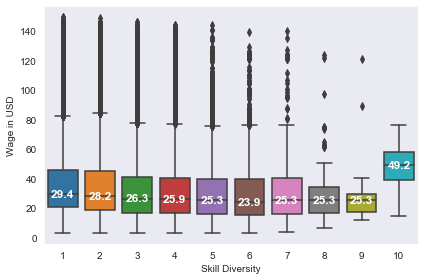

In [68]:
fig_dims = (9, 6)

fig, ds = plt.subplots(figsize=fig_dims)



box_plot = sns.boxplot(x="skill_diversity", y="adj_rate", data=df, ax=ds)

ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median  line
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=12,
        color='white')
plt.xlabel("Skill Diversity")
plt.ylabel("Wage in USD")
box_plot.figure.tight_layout()
#plt.savefig("Boxplot_wage_diversity2", dpi=300)

In [62]:
# Examine the outliers
df[df["skill_diversity"]==10]

,skills,rate,category_1,category_2,date_2,SkillScore,skill_level,0,1,2,...,diversity_2,diversity_2+,diversity_3,skill_count,unique_skills,num_projects,weighted_skill_count,quarter_year,year,adj_rate
88137,"[api, api-integration, bootstrap, cms, crm, cs...",49.0,"Web, Mobile & Software Dev",Web Development,2019-04-12,65.642857,high,9,23,1,...,0,0,1,50,4534,237810,0.011028,2019Q2,2019,46.8
372720,"[adobe-flash, adobe-pdf, advertising, amazon-w...",15.0,Admin Support,Personal / Virtual Assistant,2017-01-25,47.785714,low,4,3,1,...,0,0,1,78,3146,71147,0.024793,2017Q1,2017,14.7
540272,"[adobe-illustrator, adobe-photoshop, content-w...",54.0,Sales & Marketing,Lead Generation,2019-09-07,62.342857,medium,2,4,1,...,0,0,1,23,2961,124417,0.007768,2019Q3,2019,51.6
714530,"[2d-animation, adaptive-web-design, adobe-digi...",80.0,IT & Networking,Other - IT & Networking,2018-12-13,59.528571,medium,3,4,6,...,0,0,1,41,3020,27458,0.013576,2018Q4,2018,76.5


### 1.3 Wage and category of skill diversity (no crossing, 1 crossing, 1+ crossingd)

In [ ]:
# sns.boxplot
sns.set_style("whitegrid")
sns.boxplot(x="skill_level", y=df["wage_diff_sum_median"], data=df,order=["low", "medium","high"])
plt.xlabel("Skill level")
plt.ylabel("Wage differential in absolute USD")
#plt.savefig("Wage_diff_skill_sum", dpi=300)

In [98]:
# Correct dummies

df["diversity_2+"] = np.where(df["skill_diversity"]>2,1,0)

In [102]:
# transform data

df["diversity"] = 0
df["diversity"] = np.where(df["diversity_1"]==1,"1",df["diversity"])
df["diversity"] = np.where(df["diversity_2"]==1,"2",df["diversity"])
df["diversity"] = np.where(df["diversity_2+"]==1,">2",df["diversity"])

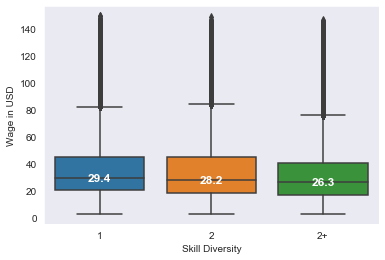

In [129]:
box_plot = sns.boxplot(x="diversity", y="adj_rate", data=df,order=["1", "2","2+"])

ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median  line
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=12,
        color='white')
plt.xlabel("Skill Diversity")
plt.ylabel("Wage in USD")
#box_plot.figure.tight_layout()
#plt.savefig("boxplot_div-dummies", dpi=300)

## 2. Regression Analyis

wages ~ number of skills requested per project + average degree centrality of project skills + job category

In [162]:
df_reg = sm.add_constant(df)

In [ ]:
df_reg.year = df_reg.year.astype(str)

In [ ]:
# Variables:
# category_1
#SkillScore
#Skill_level
#skill_diversity
#skill_count
#weighted_skill_count
#diversity
#year

## Model 1

In [136]:
mod = smf.ols(formula='adj_rate ~ skill_count + skill_level + year' 
              , data=df_reg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               adj_rate   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2392.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        09:12:54   Log-Likelihood:            -2.9571e+06
No. Observations:              653415   AIC:                         5.914e+06
Df Residuals:                  653408   BIC:                         5.914e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                36.78

## Model 2

In [137]:
mod = smf.ols(formula='adj_rate ~ skill_diversity + skill_level + year' 
              , data=df_reg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               adj_rate   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2793.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        09:14:31   Log-Likelihood:            -2.9559e+06
No. Observations:              653415   AIC:                         5.912e+06
Df Residuals:                  653408   BIC:                         5.912e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                39.22

## Model 3

In [138]:
mod = smf.ols(formula='adj_rate ~ skill_diversity + skill_count + skill_level + year' 
              , data=df_reg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               adj_rate   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2536.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        09:15:00   Log-Likelihood:            -2.9554e+06
No. Observations:              653415   AIC:                         5.911e+06
Df Residuals:                  653407   BIC:                         5.911e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                39.20

## Model 4

In [153]:
df_reg.skill_level.value_counts(dropna=False)

high      302932
medium    225879
low       124604
NaN        95355
Name: skill_level, dtype: int64

In [164]:
mod = smf.ols(formula='adj_rate ~ skill_diversity + skill_count + category_1 + year' 
              , data=df_reg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               adj_rate   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     3568.
Date:                Mon, 25 May 2020   Prob (F-statistic):               0.00
Time:                        20:30:39   Log-Likelihood:            -3.3722e+06
No. Observations:              748770   AIC:                         6.744e+06
Df Residuals:                  748753   BIC:                         6.745e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

## Model 5 - Log transform

In [145]:
df_reg["adj_rate"] = np.log(df_reg["adj_rate"])

In [147]:
df_reg["skill_diversity"] = np.log(df_reg["skill_diversity"])

In [148]:
df_reg["skill_count"] = np.log(df_reg["skill_count"])

In [158]:
mod = smf.ols(formula='adj_rate ~ skill_diversity + skill_count + category_1 + year' 
              , data=df_reg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               adj_rate   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     5454.
Date:                Mon, 25 May 2020   Prob (F-statistic):               0.00
Time:                        20:28:15   Log-Likelihood:            -6.6631e+05
No. Observations:              748770   AIC:                         1.333e+06
Df Residuals:                  748753   BIC:                         1.333e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

## Skill count

In [144]:
mod = smf.ols(formula='skill_count ~ skill_level + category_1' 
              , data=df_reg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            skill_count   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     945.7
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        09:41:50   Log-Likelihood:            -1.7407e+06
No. Observations:              653415   AIC:                         3.481e+06
Df Residuals:                  653401   BIC:                         3.482e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

## Skill diversity

In [143]:
mod = smf.ols(formula='skill_diversity ~ skill_level + category_1' 
              , data=df_reg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        skill_diversity   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     4413.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        09:41:44   Log-Likelihood:            -8.8696e+05
No. Observations:              653415   AIC:                         1.774e+06
Df Residuals:                  653401   BIC:                         1.774e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

# Other

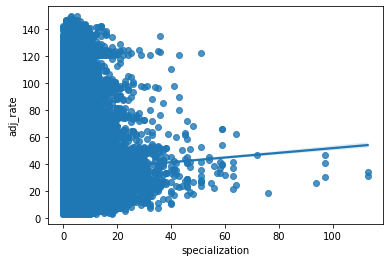

In [4]:
# wages and specialization
sns.regplot(x="specialization", y="adj_rate", data=df)

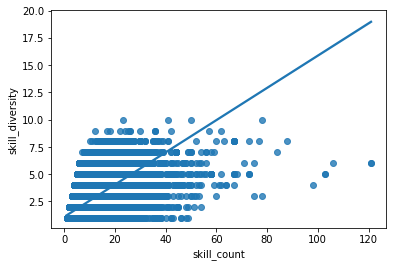

In [8]:
# wages and specialization
sns.regplot(x="skill_count", y="skill_diversity", data=df)

Text(0, 0.5, 'Wage in USD')

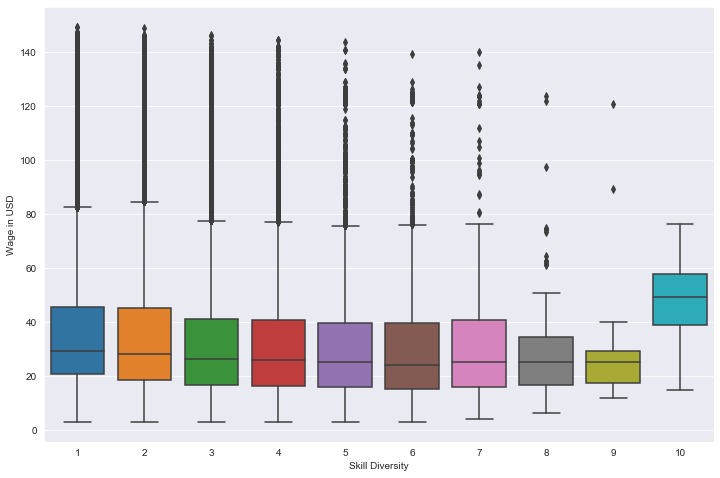

In [52]:
# boxplot

sns.set_style("darkgrid")

fig_dims = (12, 8)

fig, ax = plt.subplots(figsize=fig_dims)

sns.boxplot(x="skill_diversity", y="adj_rate", data=df, ax=ax)
plt.xlabel("Skill Diversity")
plt.ylabel("Wage in USD")

# Regression Diagnostics

Text(0, 0.5, 'Residuals')

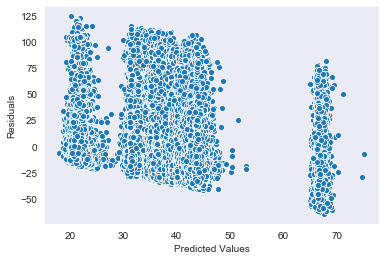

In [165]:
# Plot residuals vs. predictions

pred_val = res.fittedvalues.copy()
true_val = df_reg['adj_rate'].dropna().values.copy()
residual = true_val - pred_val

sns.scatterplot(x=pred_val ,y=residual)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
#plt.savefig("ols_residual.png", dpi=300)

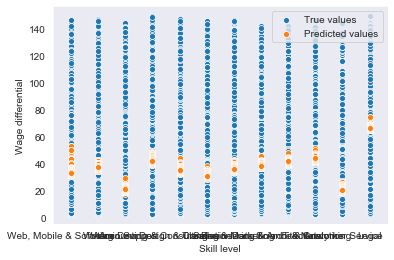

In [169]:
sns.scatterplot(x=df_reg.category_1 ,y=true_val, label="True values")
sns.scatterplot(x=df_reg.category_1 ,y=pred_val, label="Predicted values")
plt.xlabel('Skill level')
plt.ylabel('Wage differential')
plt.legend()
#plt.savefig("skill_predict.png", dpi=300)